## Q3

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import statistics

### Problem Idea

Instead of doing another regression and data problem, I will try something MNIST to see what the intrinsic dimension of the 0-9 digit images are. Before any analysis my guess is 10/11, depending on whether the blank white-space in MNIST images will be treated as part of the latent knowledge (I suspect it will be)

In [ ]:
from models import AutoencoderModel

##### Data Preparation

In [ ]:
device_name = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
data = datasets.MNIST(root='./data', download=True)
images = data.data.float().div(255).unsqueeze(1).to(device_name)

In [ ]:
batch_size = 100
learning_images, validation_images = torch.utils.data.random_split(images, [50000, 10000])
learn_loader = DataLoader(learning_images, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_images, batch_size=batch_size, shuffle=False)

In [ ]:
test_data = datasets.MNIST(root='./data', train=False, download=True)
test_images = test_data.data.float().div(255).to(device_name)
test_images_loader = DataLoader(test_images, batch_size=1, shuffle=False)

##### Model Training

In [25]:
def train_model(model, learn_loader, validation_loader, optimiser, loss_function, num_epochs):
    learning_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for images in learn_loader:
            images = images.view(-1, 28 * 28).to(device_name)
            optimiser.zero_grad()
            reconstructed_images = model(images)
            loss = loss_function(reconstructed_images, images)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()

        avg_learning_loss = total_loss / len(learn_loader)
        learning_losses.append((epoch + 1, avg_learning_loss))

        # Validation step
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for val_images in validation_loader:
                val_images = val_images.view(-1, 28 * 28).to(device_name)
                reconstructed_val_images = model(val_images)
                val_loss = loss_function(reconstructed_val_images, val_images)
                total_val_loss += val_loss.item()

        avg_validation_loss = total_val_loss / len(validation_loader)
        validation_losses.append((epoch + 1, avg_validation_loss))

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Learning Loss: {avg_learning_loss:.4f}, Validation Loss: {avg_validation_loss:.4f}")

    return learning_losses, validation_losses

In [26]:
model = AutoencoderModel(sizes=[784, 256, 64, 10, 64, 256, 784]).to(device_name)

In [27]:
learning_rate = 0.005
num_epochs = 20
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
learning_losses, validation_losses = train_model(model, learn_loader, validation_loader, optimiser, loss_function, num_epochs)

Text(0.5, 1.0, 'Validation Loss')

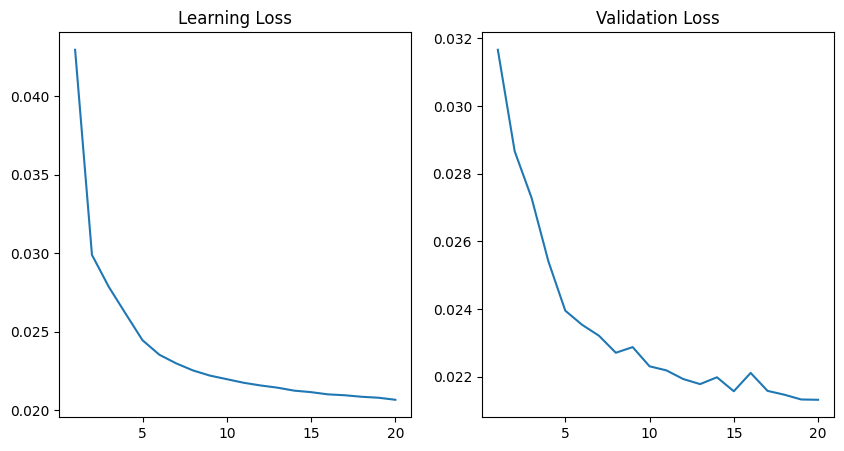

In [29]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([x[0] for x in learning_losses], [x[1] for x in learning_losses], label='Learning Loss')
plt.title('Learning Loss')
plt.subplot(1, 2, 2)
plt.plot([x[0] for x in validation_losses], [x[1] for x in validation_losses], label='Validation Loss')
plt.title('Validation Loss')

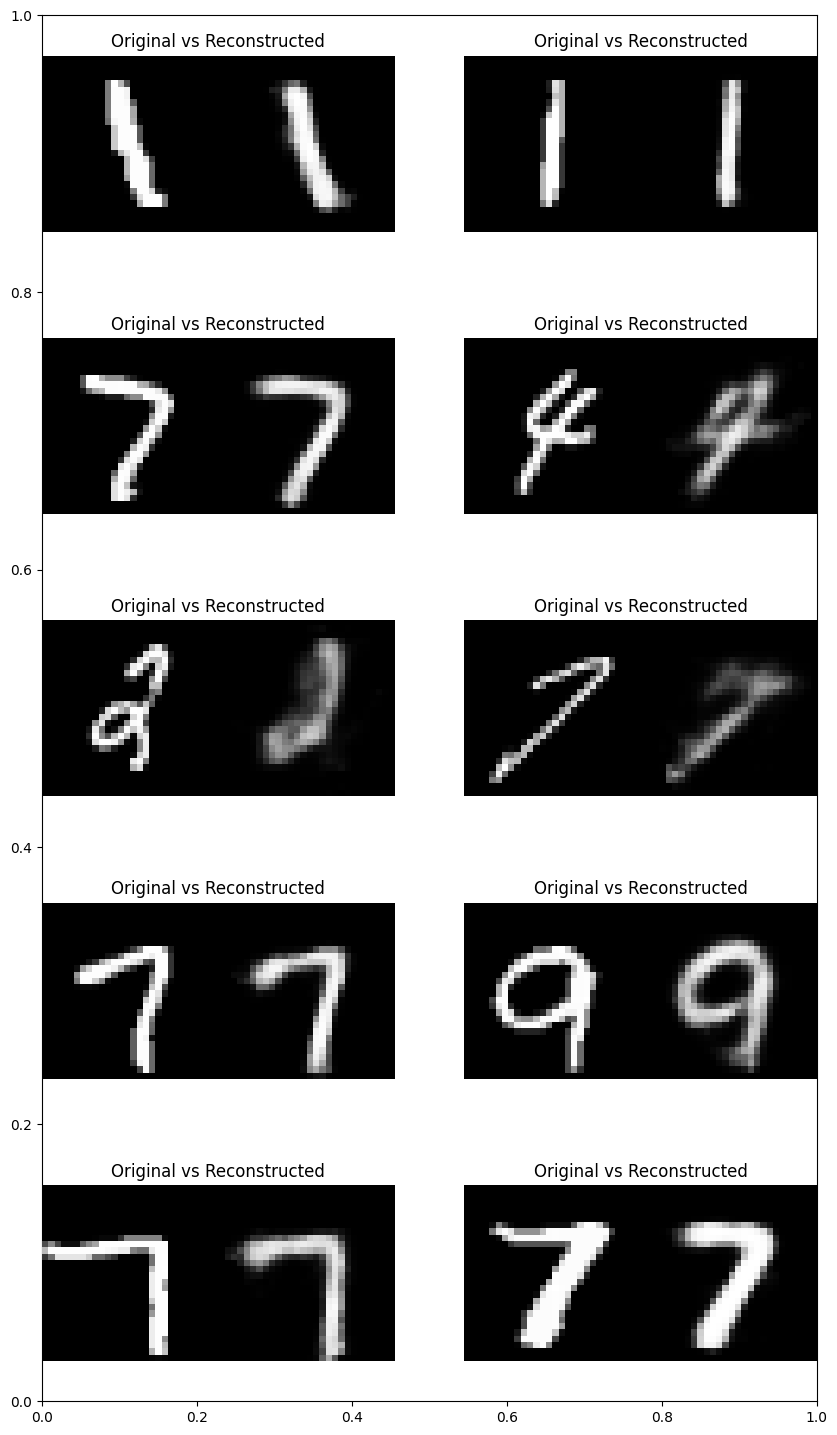

In [31]:
# From the above plots, the autoencoder seems to be learning well,
# We can explicitly reconstruct some images to get a visual confirmation

random_indices = torch.randint(0, len(images), (10,))
random_images = images[random_indices]
with torch.no_grad():
    reconstructed_images = model(random_images)

plt.figure(figsize=(10, 18))
plt.subplots_adjust(hspace=0.1)
plt.gcf().patch.set_facecolor('none')
plt.gca().set_facecolor('none')

random_images = random_images.view(-1, 28, 28)
reconstructed_images = reconstructed_images.reshape(random_images.shape)

for i in range(10):
    plt.subplot(5, 2, i + 1)
    stacked_images = torch.hstack((random_images[i].squeeze(), reconstructed_images[i]))
    plt.imshow(stacked_images.cpu(), cmap='gray')
    plt.title(f"Original vs Reconstructed")
    plt.axis('off')

##### I am not sure how to feel about the above images, so we can do some further analysis. I will plot the images which individually show the worst loss to see if I can intuitively understand what the network is missing

Average Loss: 0.0211, Standard Deviation: 0.0129


Text(0.5, 1.0, 'Individual Losses of Test Images')

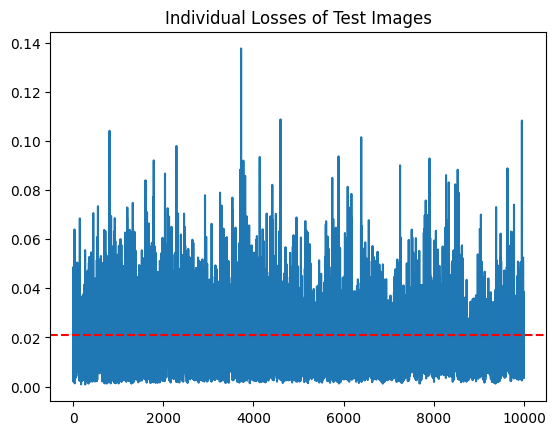

In [36]:
model.eval()
individual_losses = []

with torch.no_grad():
    for index, image in enumerate(test_images_loader):
        image = image.view(-1, 28 * 28)
        reconstructed_image = model(image).reshape(28, 28)
        loss = loss_function(reconstructed_image, image.reshape(28, 28))
        individual_losses.append((index, loss.item()))

mean = statistics.mean([x[1] for x in individual_losses])
std = statistics.stdev([x[1] for x in individual_losses])
print(f"Average Loss: {mean:.4f}, Standard Deviation: {std:.4f}")
plt.plot(*zip(*individual_losses), label='Individual Losses')
plt.axhline(mean, color='red', linestyle='--', label='Mean Loss')
plt.title('Individual Losses of Test Images')

In [ ]:
loss_benchmark = mean + 3 * std
bad_images = []

with torch.no_grad():
    for index, image in enumerate(test_images_loader):
        image = image.view(-1, 28 * 28)
        reconstructed_image = model(image)

        loss = loss_function(reconstructed_image, image)
        if loss.item() > loss_benchmark:
            bad_images.append(index)

        if len(bad_images) >= 15:
            break

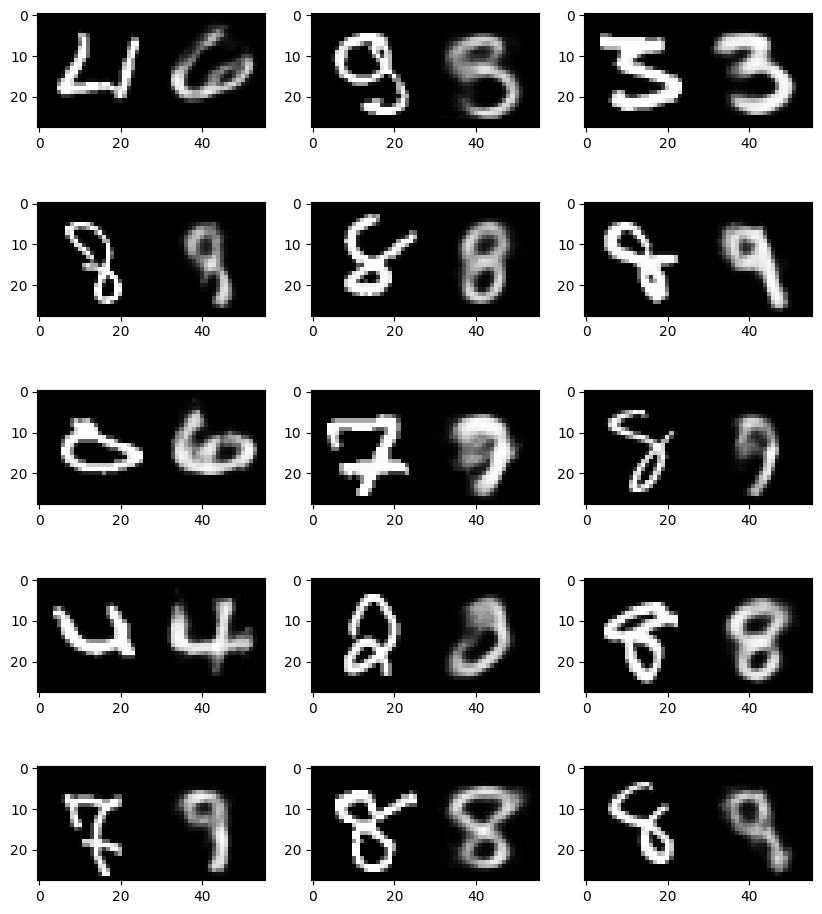

In [40]:
plt.figure(figsize=(10, 12))
plt.subplots_adjust(hspace=0.1)
num_subplots = 15

for i in range(num_subplots):
    plt.subplot(5, 3, i + 1)
    image = test_images[bad_images[i]]
    reconstructed_image = model(image.view(-1, 28 * 28)).reshape(28, 28).detach()
    stacked_images = torch.hstack((image, reconstructed_image)).cpu()
    plt.imshow(stacked_images.cpu(), cmap='gray')

##### Intuitively I feel like the latent may not be enough to capture the serious features like loops and 4/6 slashes. Could also be a training issue, because I only did 20 epochs. Lets save the model as a base reference

In [42]:
torch.save(model.state_dict(), 'model-weights/AutoencoderModel-l10.pth')

RuntimeError: Parent directory model-weights does not exist.

## Looking Inside the Autoencoder


In [ ]:
labels = data.targets.to(device_name)

In [ ]:
# Take out 20 images from each class
counts = [0] * 10
counted_images = [[] for _ in range(10)]

for image, label in zip(images, labels):
    if counts[label] < 10:
        counted_images[label].append(image)
        counts[label] += 1
    if all(c >= 10 for c in counts):
        break

assert all(len(counted_images[i]) == 10 for i in range(10))

In [ ]:
# Find the latents of the counted images

counted_latents = []
with torch.no_grad():
    for label in range(10):
        all_images = torch.stack(counted_images[label])
        latents = model.encoder_forward(all_images)
        counted_latents.append(latents)

assert len(counted_latents) == 10
assert all(counted_latents[i].shape == (10, 10) for i in range(10))

In [ ]:
# Find average latent value
one_hot_latents = torch.zeros((10, 10)).to(device_name)
for i in range(10):
    one_hot_latents[i][i] = 10

reconstructed_images = model.decoder_forward(one_hot_latents).reshape(-1, 28, 28)

plt.figure(figsize=(10, 15))
plt.subplots_adjust(hspace=0.2)
for i in range(10):
    plt.subplot(5, 2, i + 1)
    image = reconstructed_images[i].detach().cpu()
    plt.imshow(image, cmap='gray')
    plt.title(f"Latent {i}")


In [ ]:
i = 4
j = 0
print(counted_latents[i][j])
plt.imshow(counted_images[i][j][0].cpu(), cmap='gray')

j = 1
print(counted_latents[i][j])
plt.imshow(counted_images[i][j][0].cpu(), cmap='gray')